In [ ]:
# 9.1图像增广 image augmentation
# 通过对训练图像做一系列随机改变，产生相似但又不同的训练样本
# 从而扩大训练集的规模
# 图像增广的另一种解释： 通过随机改变训练样本来降低模型对样本的某些属性的依赖
# 从而提高模型的泛化能力
# 列入通过对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，也可以调整亮度色彩
# 等因素，在AlexNet的成功中，图像增广技术功不可没

%matplotlib inline
import time
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torchvision
from PIL import Image

import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 常用的图像增广方法
d2l.set_figsize()
img = Image.open('../img/cat1.jpg')
d2l.plt.imshow(img)

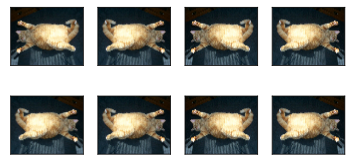

In [12]:
# 下面定义绘图函数show_images
def show_image(imgs,num_rows,num_cols,scale=2):
    figsize = (num_cols*scale,num_rows*scale)
    _,axes = d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

# 大部分图像增广方法都有一定的随机性。为了方便观察图像增广的效果，接下来我们定义一个个
# 辅助函数apply，这个函数多次运行图像增广方法aug并展示所有的结果
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y = [aug(img) for _ in range(num_rows*num_cols)]
    show_image(Y,num_rows,num_cols,scale)
  
# 水平翻转
apply(img,torchvision.transforms.RandomHorizontalFlip())


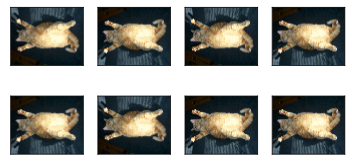

In [10]:
# 垂直翻转
apply(img,torchvision.transforms.RandomVerticalFlip())

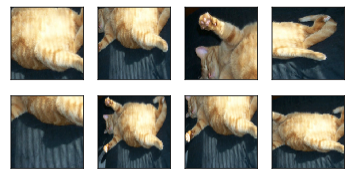

In [11]:
# 裁剪
shape_aug = torchvision.transforms.RandomResizedCrop(200,scale=(0.1,1),ratio=(0.5,2))
apply(img,shape_aug)

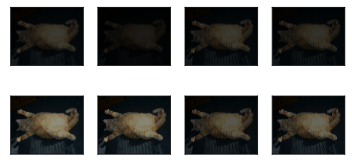

In [13]:
# 颜色变化
# 从四个方面改变图像的颜色：
# 1.亮度     brightness
# 2.对比度   contrast
# 3.饱和度   saturation
# 4.色调     hue
apply(img,torchvision.transforms.ColorJitter(brightness=(0.1,0.6)))

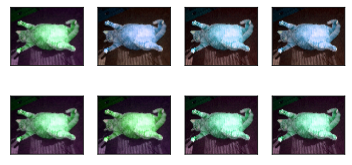

In [15]:
apply(img,torchvision.transforms.ColorJitter(hue=(0.2,0.5)))

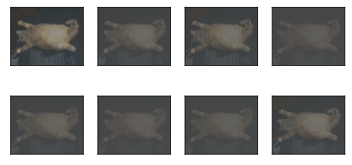

In [16]:
apply(img,torchvision.transforms.ColorJitter(contrast=(0.1,0.5)))

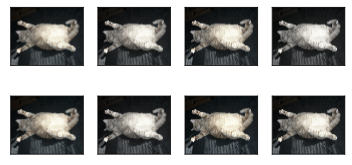

In [18]:
apply(img,torchvision.transforms.ColorJitter(saturation=(0.1,0.6)))

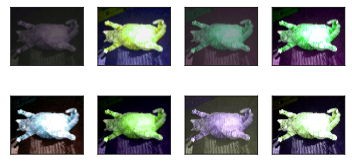

In [19]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

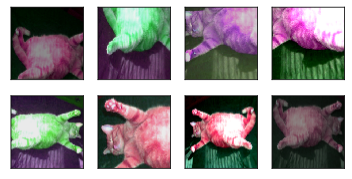

In [20]:
# 叠加多个图像的增广方法，使用Compose
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                      color_aug,shape_aug])
apply(img,augs)

In [ ]:
# 使用图像增广训练模型
# 这里使用CIFAR-10数据集，而非Fashion-MNIST数据集，因为Fashion—MNIST数据集中的物体
# 的尺寸和位置都已经经过归一化处理，CIFAR-10中的物体中的颜色和大小区别更加显著

import torchvision
all_imges = torchvision.datasets.CIFAR10(train=True,root="~/Datasets/CIFAR",download=
                                        True)
# all_imges的每一个元素都是（iamge,label）
show_image()
# 为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用
# 含随机操作的图像增广 使用ToTensor将小批量图像转换成pytorch所需要的格式
# （批量大小，通道数，高，宽）值域在0到1之间且类型为32位的浮点数
flip_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

no_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# 接下来定义一个辅助函数来方便读取图像并应用图像增广
num_workers = 0 if sys.platform.startwith('win32') else 4
def load_cifar10(is_train,augs,batch_size,root="~/Datasets/CIFAR"):
    datasets = torchvision.datasets.CIFAR10(root=root,train=is_train,transforms=augs,download=True)
    return DataLoader(datasets,batch_size=batch_size,shuffle=is_train,num_workers=num_workers)

# 使用图像增广训练模型
def train(train_iter,test_iter,net,loss,optimizer,device,num_epochs):
    net = net.to(device)
    print("training on",device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start = 0.0,0.0,0.0,time.time()
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y_hat).sum().cpu().item()
            n += y_hat.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter,net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    
# 接下来就可以定义train_with_data_aug函数使用图像增广来训练模型了。该函数使用Adam算法作为训练优化算法
def train_with_data_aug(train_augs,test_augs,lr = 0.0.001):
    batch_size,net = 256,d2l.resnet18()
    optimizer = torch.optim.Adam(net.parameters(),lr = lr)
    loss = torch.nn.CrossEntropLoss()
    train_iter = load_cifar10(True,train_augs,batch_size)
    test_iter = load_cifar10(True,test_augs,batch_size)
    train(train_iter,test_iter,net,loss,optimizer,device,num_epochs=10)

train_with_data_aug(flip_aug,no_aug)